# Project: Deep Learning: Neural Networks - Toxic Comment Filter

Building a model capable of filtering user comments based on the degree of harmfulness of the language:

1. Preprocess the text by removing tokens that do not provide significant semantic contribution.
2. Transform the text corpus into sequences.
3. Build a Deep Learning model including recurrent layers for a multilabel classification task.
4. At prediction time, the model must return a vector containing a 1 or a 0 corresponding to each label present in the dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). In this way, a non-harmful comment will be classified by a vector of only 0s [0,0,0,0,0,0]. Conversely, a harmful comment will have at least one 1 among the 6 labels.

# 0 Project Analysis

The project constists to build a AI model capable of filtering user comments based on the degree of harmfulness of the language.

It will works such as a filter for anti-hater on Social Networks.

To solve the project the following tasks are suggested to follow:

## 1. Proprocess the text

For the preprocessing of text it needs to remove all semantic contribution from the text (comments) in order to have only the words necessary for the task.

In this case, it will be used the keras tokenizer using properly the filters.

- tf.keras.preprocessing.text.Tokenizer


```
  tf.keras.preprocessing.text.Tokenizer(
      num_words=None,
      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
      lower=True,
      split=' ',
      char_level=False,
      oov_token=None,
      analyzer=None,
      **kwargs
  )
```

In this way all non necessary words will be removed from texts.

## 2. Transform corpus in sentences

To trasform the texts in a sentences, it will be used the texts_to_sequences of keras framework.
It needs to trasform the corpus in a list of sequences.

```
tf.keras.preprocessing.text.Tokenizer.texts_to_sequences(
    texts
)
```

In this way, the order of words for each sequences are stored and learned from neural network during the training.

## 3. Build Deep Learning model with Recurrent Layers (RNN)

Once the preprocessing is completed and pass through the first and second task, the data is ready to be used by the model and then go towards training.

## 4. Transform binary predictions

At model completion, during the prediction time, a calculation of properly thresholds will be executed in roder to convert the probability of associated labels to 0 and/or 1.

# 1 Import Section

In [1]:
# Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import random
from scipy.optimize import nnls

# Pre-processing
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

# Models - Neural Network - Layers
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, Flatten, GlobalMaxPooling1D, BatchNormalization, GRU
from keras.callbacks import EarlyStopping, Callback
from keras.regularizers import l2
from keras.optimizers import Adam

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

# 2 Constant Declaration

In [2]:
# Random seed for reproducible results
RANDOM_SEED = 0

# Base URL where download the dataset
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"

# Dataset name
DATASET_NAME = "Filter_Toxic_Comments_dataset.csv"

# Dataset URL
DATASET_URL = BASE_URL + DATASET_NAME

# Labels - Columns of dataset
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat',	'insult', 'identity_hate']

# Labels - Count
LABELS_COUNT = 6

# 3 Classes & Functions Definition Section

## 3.1 Functions: Data Pre-Processing



In [3]:
def preprocess_text(text: str):
  """
  Function used to preprocess the text and delete semantic contribution such as punctuation, numbers and spaces.

  Parameters:
    - text: String --> Input text to process.

  Return:
    - text: String --> Processed text.
  """

  # Make the text lower
  text = text.lower()

  # Apply the Regex to text removing: punctuation, spaces and numbers
  text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'\s+', ' ', text)

  # Return the text processed
  return text.strip()

## 3.2 Functions: Statistics Analysis

In [4]:
def build_conditional_prob_matrix(df, labels):
    """
    Function used to create the conditional probability matrix.

    Parameters:
      - df: pd.DataFrame --> Dataframe from retrieve the data
      - labels: String --> Name of the column

    Return:
      - None
    """
    cooc = df[labels].values.T.dot(df[labels].values)
    cooc_norm = cooc.copy().astype(np.float32)
    for i in range(cooc_norm.shape[0]):
        cooc_norm[:, i] /= cooc[i, i]
    return cooc_norm

In [5]:
def fancy_sample(df, labels, target_count, cond_prob):
    """
    Function used to create the fancy sample.

    Parameters:
      - df: pd.DataFrame --> Dataframe from retrieve the data
      - labels: String --> Name of the column
      - target_count: Integer --> Number of samples to create
      - cond_prob: Numpy array --> Conditional probability matrix

    Return:
      - sampled_df: pd.DataFrame --> Sampled dataframe
    """
    target_counts = np.array([target_count for _ in labels])
    optimal_samples, residuals = nnls(cond_prob, target_counts)
    optimal_samples = np.ceil(optimal_samples).astype(np.int32)

    df_subs = []
    for i, label in enumerate(labels):
        sub_df = df[df[label] == 1]
        df_subs.append(sub_df.sample(optimal_samples[i],
                                     replace = len(sub_df) < optimal_samples[i]))
    sampled_df = pd.concat(df_subs)
    return sampled_df

In [6]:
def plot_learning_curves(hist, exp_name: str):
    """
    Function used to plot the loss and accuracy trend during model training.

    Parameters:
        - hist: History object --> Contains all the information of model training.
        - exp_name: String --> Name to give to plot title.
    """
    # Plot the loss and accuracy
    plt.figure(figsize=(10,4))
    for subplot,curve in enumerate(['loss','accuracy']):
        plt.subplot(1,2,subplot+1)
        plt.plot(hist.history[curve],label='training')
        plt.plot(hist.history['val_'+curve],label='validation')
        plt.legend()
        plt.title(exp_name+':'+curve)
    plt.tight_layout();

In [7]:
def plot_distribution_barplot(df, column_name):
    """
    Function used to create barplot for frequency distribution of selected variable.

    Parameters:
      - df: pd.DataFrame --> Dataframe from retrieve the data
      - column_name: String --> Name of the column to plot

    Return:
      - None
    """
    # Columns to count for classes
    class_counts = df[column_name].sum().sort_values(ascending=False)

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Create barplot with data calculated
    sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, legend=False)

    # Set plot legends
    plt.title('Labels Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

In [8]:
def plot_words_frequencies(df):
    """
    Function used to plot the words frequencies.

    Parameters:
      - df: pd.DataFrame --> Dataframe from retrieve the data

    Return:
      - None
    """
    # Create the figure
    plt.figure(figsize=(10, 6))

    # Create barplot with data calculated
    sns.histplot(df['comment_length'], bins=50, kde=True)

    # Set plot legends
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.title('Distribution of Comment Lengths')

    # Show the plot
    plt.show()

In [9]:
def plot_cumulative_distribution(cumulative_percentage):
    """
    Plot the cumulative distribution of word frequencies.

    Parameters:
      - cumulative_percentage (list or array-like): A list or array containing the cumulative percentage of total words.
    """
    # Create the figure
    plt.figure(figsize=(10, 6))

    # Create lineplot with data calculated
    sns.lineplot(x=range(1, len(cumulative_percentage) + 1), y=cumulative_percentage)

    # Set legends
    plt.xlabel('Number of Words')
    plt.ylabel('Cumulative Percentage of Total Words')
    plt.title('Cumulative Word Distribution')

    # Add a horizontal line at 95%
    plt.axhline(y=95, color='r', linestyle='--')
    plt.axvline(x=len([p for p in cumulative_percentage if p <= 95]), color='r', linestyle='--')

    # Show the plot
    plt.show()


## 3.3 Functions: Model Creation and Utils

In [10]:
def convert_predictions_to_binary(predictions, threshold=0.5):
    """
    Trasform the predictions array in binary array.

    Parameters:
        - predictions: List --> Predictions list (probability)
        - threshold: Float --> Threshold to convert 1 and 0 predictions (default=0.5)

    Return:
        - List of binary arrays
    """

    # Take predictions and set them at 0 or 1 related to threshold
    binary_predictions = (predictions >= threshold).astype(int)

    # Returns the binary predictions
    return binary_predictions

In [11]:
def create_baseline_model(vocabulary_size, max_sequence_length, labels_count):
    """
    Function used to create the baseline model.

    Parameters:
      - vocabulary_size: Integer --> Number of words in vocabulary
      - max_sequence_length: Integer --> Max length of sequences
      - labels_count: Integer --> Number of labels to predict

    Return:
      - model: Sequential --> Baseline model
    """
    # Create the Sequential model
    model = Sequential()

    # Add Embedding, LSTM, Dropout and Dense layers
    model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=max_sequence_length))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(labels_count, activation='sigmoid'))

    # Compile the neural network
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Return the NN model
    return model

In [12]:
def create_bilstm_model(vocabulary_size, max_sequence_length, labels_count):
    """
    Function used to create the BiLSTM model.

    Parameters:
      - vocabulary_size: Integer --> Number of words in vocabulary
      - max_sequence_length: Integer --> Max length of sequences
      - labels_count: Integer --> Number of labels to predict

    Return:
      - model: Sequential --> BiLSTM model
    """
    # Create the Sequential model
    model = Sequential()

    # Add Embedding, LSTM, Dropout and Dense layers
    model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=max_sequence_length))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(labels_count, activation='sigmoid'))

    # Compile the neural network
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Return the NN model
    return model

In [13]:
def create_gru_model(vocabulary_size, max_sequence_length, labels_count):
    """
    Function used to create the GRU model.

    Parameters:
      - vocabulary_size: Integer --> Number of words in vocabulary
      - max_sequence_length: Integer --> Max length of sequences
      - labels_count: Integer --> Number of labels to predict

    Return:
      - model: Sequential --> GRU model
    """
    # Create the Sequential model
    model = Sequential()

    # Add Embedding, GRU, Dropout and Dense layers
    model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=max_sequence_length))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(labels_count, activation='sigmoid'))

    # Compile the neural network
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Return the NN model
    return model

In [14]:
def create_biltsm_normalization_model(vocabulary_size, max_sequence_length, labels_count):
    """
    Function used to create the BiLSTM model with normalization.

    Parameters:
      - vocabulary_size: Integer --> Number of words in vocabulary
      - max_sequence_length: Integer --> Max length of sequences
      - labels_count: Integer --> Number of labels to predict

    Return:
      - model: Sequential --> BiLSTM model with normalization
    """
    # Create the Sequential model
    model = Sequential()

    # Add Embedding, LSTM, Dropout, BatchNormalization and Dense layers
    model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=max_length))
    model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.01))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(labels_count, activation='sigmoid'))

    # Compile the neural network
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    # Return the NN model
    return model

In [15]:
def create_model_with_class_weights(vocabulary_size, max_sequence_length, labels_count, X_train, y_train):
    """
    Function used to create the model with class weights.

    Parameters:
      - vocabulary_size: Integer --> Number of words in vocabulary
      - max_sequence_length: Integer --> Max length of sequences
      - labels_count: Integer --> Number of labels to predict
      - X_train: Numpy array --> Train data
      - y_train: Numpy array --> Train labels

    Return:
      - model: Sequential --> Model with class weights
    """
    # Create the Sequential model
    model = Sequential()

    # Add Embedding, LSTM, Dropout and Dense layers
    model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=max_sequence_length))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(labels_count, activation='sigmoid'))

    # Compile the neural network
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Compute the class weights
    class_weights = {}
    for i in range(y_train.shape[1]):
        class_weight = compute_class_weight('balanced', classes=np.unique(y_train[:, i]), y=y_train[:, i])
        class_weights[i] = class_weight

    # Flatten the class weights dictionary
    flattened_class_weights = {}
    for class_label in class_weights:
        flattened_class_weights[class_label] = class_weights[class_label][1]

    # Fit the model with calculated weights
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=flattened_class_weights)

    # Return the NN model
    return model

In [16]:
def generate_classification_report(model, X_test, y_test, thresholds):
    """
    Function used to generate the classification report.

    Parameters:
      - model: Sequential --> Model to evaluate
      - X_test: Numpy array --> Test data
      - y_test: Numpy array --> Test labels
      - thresholds: List or Numpy array --> Threshold values for each label

    Return:
      - None
    """
    # Generate predictions
    y_pred = model.predict(X_test)

    # Convert predictions to binary based on thresholds
    y_pred_binary = np.zeros_like(y_pred)
    for i, threshold in enumerate(thresholds):
        y_pred_binary[:, i] = (y_pred[:, i] >= threshold).astype(int)

    # Print classification report
    print(classification_report(y_test, y_pred_binary, target_names=LABELS))

In [17]:
def plot_model_performance(title, x_label, y_label, x, y, data):
    """
    Plot the performance of different models in terms of Test Accuracy and Test Loss.

    Parameters:
      - title (str): The title of the plot.
      - x_label (str): The label for the x-axis.
      - y_label (str): The label for the y-axis.
      - x (str): The name of the column to use for the x-axis.
      - y (str): The name of the column to use for the y-axis.
      - data (DataFrame): The DataFrame containing the data to plot.

    Returns:
      - None
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x, y=y, data=data, palette='viridis')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [18]:
def process_and_predict_comments(dict_comments, tokenizer, model_with_weights, max_length, thresholds):
    """
    Function used to process and predict comments.

    Parameters:
      - dict_comments: Dict --> Dictionary of comments to predict
      - tokenizer: Object --> Tokenizer object
      - model_with_weights: Object --> Model with weights
      - max_length: Integer --> Max length of sequences

    Return:
      - None
    """
    for label, comments in dict_comments.items():
        print(f"\nLabel: {label}")

        # Convert text into sequences
        comments_sequence = tokenizer.texts_to_sequences(np.array(comments))

        # Apply the padding to sentences
        padded_comments_sequence = pad_sequences(comments_sequence, maxlen=max_length)

        # Predict the class to sentences
        predictions = model_with_weights.predict(padded_comments_sequence)

        # Convert the prediction into binary
        binary_predictions = convert_predictions_to_binary(predictions, threshold=thresholds)

        # Print the 5 comments for each label
        for i in range(min(5, len(comments))):
            print(f"Comment: {comments[i]}")
            print(f"Binary Prediction: {binary_predictions[i]}\n")

In [19]:
def find_best_thresholds(y_true, y_prob):
    """
    Function used to identify the best threshold for each label.

    Parameters:
      - y_true: Numpy array --> True labels
      - y_prob: Numpy array --> Predicted probabilities

    Return:
      - best_thresholds: List --> List of best thresholds for each label
    """
    thresholds = np.linspace(0, 1, 101)
    best_thresholds = []

    for i in range(y_true.shape[1]):
        best_f1 = 0
        best_threshold = 0

        for threshold in thresholds:
            y_pred = (y_prob[:, i] >= threshold).astype(int)
            f1 = f1_score(y_true[:, i], y_pred)

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        print(f"Best threshold for label {i} is {best_threshold:.2f} with F1 score {best_f1:.4f}")

    return best_thresholds

## 3.4 Class: F1 Score Callback (Keras)

In [20]:
class F1ScoreCallback(Callback):
    def __init__(self, validation_data, patience=5, verbose=1):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.patience = patience
        self.verbose = verbose
        self.best_weights = None
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (self.model.predict(self.validation_data[0]) > 0.5).astype(int)
        val_targ = self.validation_data[1]
        current_score = f1_score(val_targ, val_predict, average='weighted')

        if self.verbose > 0:
            print(f'\nEpoch {epoch+1}: F1-Score: {current_score:.4f}')

        if current_score > self.best_score:
            self.best_score = current_score
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose > 0:
                    print(f'Restoring model weights from the end of the best epoch: {epoch - self.patience + 1}')
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)

# 4 Load Dataset: Social Network Comments

In [21]:
# Read the dataset as csv from base url defined
df = pd.read_csv(DATASET_URL)

In [22]:
# Show the first 5 rows of dataset
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


# 5 EDA - Exploration Data Analysis

## 5.1 Dataset General Information

In [23]:
# Show dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


Column '*comment_text*' contains the comments of social network to be analyzed anc classified by model.
The remains columns are related to the labels, classification of each comment.
In particular, each comment could be associated to more **than 1 label** and than there is a **multilabel classification**.

## 5.2 Features Anaslysis: Comments

In [24]:
# Number of comments to print
num_samples_per_label = 10

# For each labels print 10 random comments (negative comments)
for label in LABELS:
    print(f"Label: {label}")
    sample_comments = df[df[label] == 1].sample(n=num_samples_per_label, random_state=42)['comment_text']
    for i, comment in enumerate(sample_comments, 1):
        print(f"{i}. {comment}")
    print("\n" + "-"*50 + "\n")

Label: toxic
1. Hi! 

I wanna rape you!
2. Terrorize 
I will terrorise you for as long as you live - you are an arrogant, disgusting and rude excuse for a human being & you are going to die soon so I suggest you stop threatening people you bastard.
3. Being blocked

So that's your idea of mediation, is it? R Lopez can run amok through Wikipedia with his lying crap, and I get blocked for stating my intention of stopping him unless Wikipedia's rather creaky structures do so. I've seen some silly things since I have been editing here but that would be the silliest.
4. Editing Wikipedia 

Fuck You, you anal rapist
5. So the fact that the US Govt wants to put some dude in jail for 6 yrs is irrelevant to you?  The fact that the US Govt wants some dude to PAY restitution in over $160,000 to celebrites is irrelevant to you?  You act like that kind of stuff happens every day.  But I challenge you to name one other person that is has happened to, on the scale that this has happened, anywhere in 

In [25]:
# Print the positive comments
print("Label: sum_injurious == 0 (Positive Comment)")
sample_positive_comments = df[df['sum_injurious'] == 0].sample(n=num_samples_per_label, random_state=RANDOM_SEED)['comment_text']
for i, comment in enumerate(sample_positive_comments, 1):
    print(f"{i}. {comment}")
print("\n" + "-"*50 + "\n")

Label: sum_injurious == 0 (Positive Comment)
1. "I do not understand this sentence: ""Several authors have criticised the historical inaccuracies perpetrated upon Auschwitz [...]"" It sounds a bit like Colorless green ideas sleep furiously to me. Can an innaccuracy be perpetrated?

Perhaps some elaboration is necessary to, because we don't know what innacuracies these are.branko
"
2. "
Thanks. I don't really mind the attacks. My neighbor has a small yappy dog so I'm used to this kind of noise. ''' - talk''' "
3. ", 29 October 2007 (UTC)

This is a ""spinout"" article, and therefore not a violation of POV fork. The other two articles, Militia and a spinoff from it, Militia (United States), have been gathering too much wordage about the constitutional militia movement, which is unbalancing them. The movement is distinct from what the movement is about. Of course, it is ""related"" to the broader articles, and there are links back to them, but there is enough material peculiar to the move

Showing 10 random comments fo each label and for comments that haven't associated label, it is possible to notice that they are **badly formatted** and there are a lot of **punctuation and stop words to be deleted**.

## 5.3 Dataset Balance Analysis

Lets try to understand the balance of dataset and check the amont of samples for each label.

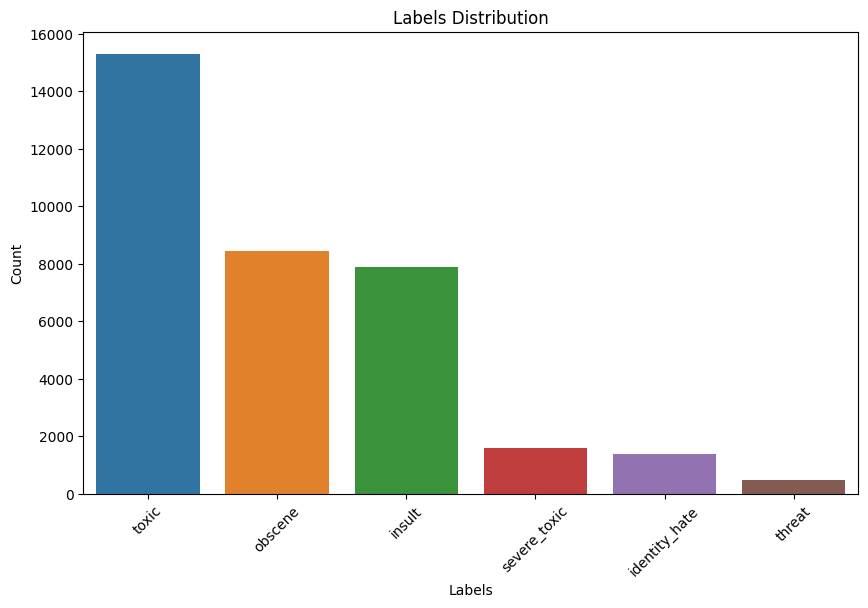

In [26]:
# Plot the classes distribution
plot_distribution_barplot(df, LABELS)

As shown by histogram the dataset is completely unbalanced.
The minor classes are severe_toxic, threat and identity_hate.
For toxic label there are huge amount of sampler compared with other labels.

The dataset at the currently status **is not good for a AI model training**.
This could generate a bad metrics for minority labels and hard recognization for them.

It needs to be more balanced.

The algorithms for implement ad oversampling or undersampling d**o not support the multilabel classification** and then it is **not possible to generate synthetic data to balance the dataset**.

Currently, there is an open issue on GitHub for scikit-learn for adding the **MLSMOTE** to the official library at following link: https://github.com/scikit-learn-contrib/imbalanced-learn/pull/927

So another way to balance the dataset is required.

Exploring on internet, as mentioned by following article (https://medium.com/gumgum-tech/creating-a-balanced-multi-label-dataset-for-machine-learning-9945abad2616), in multilabel classification is important to study the correlation and conditional probability between the labels that because each sample could be associated to more than one label and then the statistic relationship between labels could be explained by dataset with a minor number of sample.  

In [27]:
# Correlation plot for labels
corr = df[LABELS].corr()
corr.style.background_gradient(cmap='coolwarm')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


As shown by the correlation matrix the labels toxic, obscene and insult are strongly correlated between them and explain the probability of one label occurring for the same input as another

This data suggests that these labels could be explained from one of them and taking one sample with toxic

At this point, lets study the conditional probability between labels in order to understand the probability of selecting a sample with specific label appears the other ones.

In [28]:
# Conditional probability matrix
cooc_norm = build_conditional_prob_matrix(df, LABELS)
cooc_df = pd.DataFrame(cooc_norm, columns = LABELS, index = LABELS)
cooc_df.style.background_gradient(cmap = 'coolwarm')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,1.000000,0.938099,0.939331,0.932335,0.926690
severe_toxic,0.104289,1.000000,0.179548,0.234310,0.174051,0.222776
obscene,0.518242,0.951097,1.000000,0.629707,0.781389,0.734520
threat,0.029358,0.070219,0.035626,1.000000,0.038974,0.069751
insult,0.480188,0.859561,0.728489,0.642259,1.000000,0.825623
identity_hate,0.085131,0.196238,0.122145,0.205021,0.147264,1.000000


As shown by conditional probability matrix, selecting a sample with toxic label, it takes for sure also svere_toxic e probably the other ones.
The same between obscene and severe_toxic, and identity_hate and insult.

Using the conditional probability matrix data it is possible to calculate the NNS (*Non-Negative Least Squares*) to solve the linear equation of matrix.

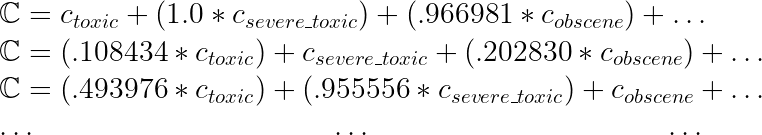

In [29]:
df_balanced = fancy_sample(df, LABELS, 3000, cooc_norm)
df_labels = df[LABELS]
print(len(df_labels))
df_labels.sum()

159571


,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


In this way, keeping the **statistic relationship between labels**, a specified numbers of sample are *selected from fancy_sample function*.

Now, it is also important to save into dataframe the sample with 0 sum_injurious because the model needs to indetify also non-harmful comments.

In [30]:
# Select non toxic comments
non_toxic_samples = df[df['sum_injurious'] == 0]

In [31]:
# Take from non toxic comments a limited number of sampler
sample_size = 3000
if len(non_toxic_samples) >= sample_size:
    sampled_non_toxic = non_toxic_samples.sample(n=sample_size, random_state=RANDOM_SEED)

Check the dimension and information about dataframe created with only non-harmful comments.

In [32]:
# Show dataset information
sampled_non_toxic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 118677 to 7019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   comment_text   3000 non-null   object
 1   toxic          3000 non-null   int64 
 2   severe_toxic   3000 non-null   int64 
 3   obscene        3000 non-null   int64 
 4   threat         3000 non-null   int64 
 5   insult         3000 non-null   int64 
 6   identity_hate  3000 non-null   int64 
 7   sum_injurious  3000 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 210.9+ KB


In [33]:
# Show dataset samples
sampled_non_toxic

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
118677,"""I do not understand this sentence: """"Several ...",0,0,0,0,0,0,0
136088,"""\nThanks. I don't really mind the attacks. My...",0,0,0,0,0,0,0
52079,""", 29 October 2007 (UTC)\n\nThis is a """"spinou...",0,0,0,0,0,0,0
8219,2010 Formula One season,0,0,0,0,0,0,0
3084,"""Welcome!\n\n \n\nHello, , to Wikipedia! I'm ,...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4801,I would not like to see this section created. ...,0,0,0,0,0,0,0
157368,Untrue. I *respected* my time-out and did NO e...,0,0,0,0,0,0,0
21469,Agreed - my logic for that text is that if Vir...,0,0,0,0,0,0,0
127993,"""\n\nNPOV Dispute - Cont'd\n\nIn an attempt to...",0,0,0,0,0,0,0


In [34]:
# Concatenate the both dataframe to create the new one
df = pd.concat([df_balanced, sampled_non_toxic], ignore_index=True)

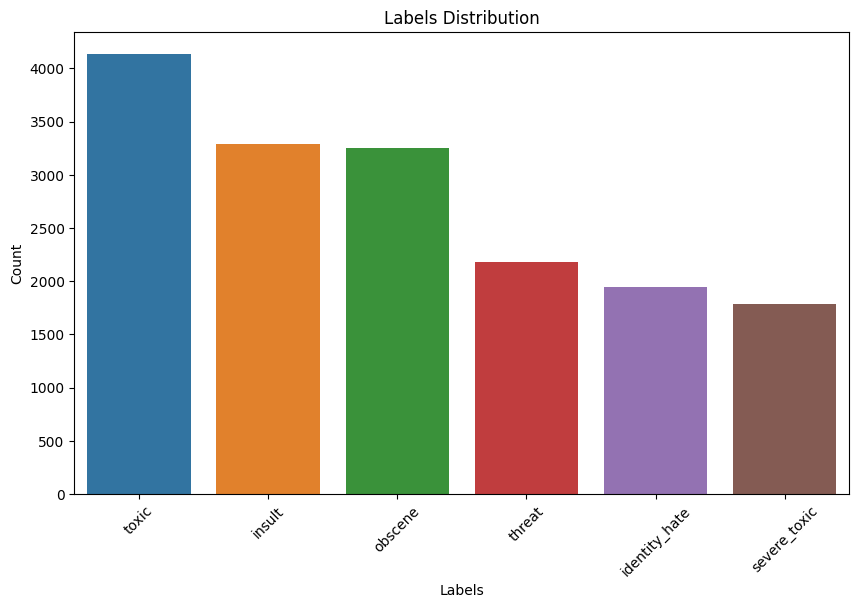

In [35]:
# Plot class distribution
plot_distribution_barplot(df, LABELS)

As shown by histogram, the **balance between labels is reduced from original dataset shape**.

At current status, it could be used for an AI model training.

## 5.4 Preprocessing Comments: Data Cleaning

Remove from comments semantic contribution such as punctuation, numbers and spaces

In [36]:
# Clean the comment and store them into dataset
df['cleaned_comment'] = df['comment_text'].apply(preprocess_text)

# Show the new dataset
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,cleaned_comment
0,"dickhead dickhead, your a dickhead, you can ta...",1,1,1,0,1,0,4,dickhead dickhead your a dickhead you can take...
1,FUCK \nYou little bitch the cowboys have no te...,1,1,1,0,1,0,4,fuck you little bitch the cowboys have no testes
2,facist muslim fuck face\nis what u r. bitch. f...,1,1,1,0,1,1,5,facist muslim fuck face is what u r bitch fuck...
3,BKBKBKBK\nIM SOOO SORRY FOR SAYIN THOSE NAUGHT...,1,1,1,0,1,1,5,bkbkbkbk im sooo sorry for sayin those naughty...
4,fuck you george \n\nakhtak sharmota,1,1,1,0,1,0,4,fuck you george akhtak sharmota


## 5.5 Words Coverage Analysis

### 5.5.1 Words Length Analysis

Calculate the comment length for each sample

In [37]:
# Calculate the comment length and store them into dataset
df['comment_length'] = df['cleaned_comment'].apply(lambda x: len(x.split()))

# Show the new dataset
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,cleaned_comment,comment_length
0,"dickhead dickhead, your a dickhead, you can ta...",1,1,1,0,1,0,4,dickhead dickhead your a dickhead you can take...,27
1,FUCK \nYou little bitch the cowboys have no te...,1,1,1,0,1,0,4,fuck you little bitch the cowboys have no testes,9
2,facist muslim fuck face\nis what u r. bitch. f...,1,1,1,0,1,1,5,facist muslim fuck face is what u r bitch fuck...,13
3,BKBKBKBK\nIM SOOO SORRY FOR SAYIN THOSE NAUGHT...,1,1,1,0,1,1,5,bkbkbkbk im sooo sorry for sayin those naughty...,371
4,fuck you george \n\nakhtak sharmota,1,1,1,0,1,0,4,fuck you george akhtak sharmota,5


Show the basic statistics of dataset

In [38]:
# Calculate the base statistics
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,comment_length
count,7343.000000,7343.000000,7343.000000,7343.000000,7343.000000,7343.000000,7343.000000,7343.000000
mean,0.563258,0.243225,0.442462,0.296609,0.447910,0.265014,2.258477,63.074765
std,0.496016,0.429059,0.496712,0.456794,0.497313,0.441371,2.081210,131.536112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,26.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000,56.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1403.000000


**Count**: All columns have 4343 entries, indicating there are no missing values.

**Mean**:

* Most comments are labeled as "toxic" with a mean of 0.95.
* About 40% of comments are labeled "severe_toxic."
* Around 73% are labeled "obscene."
* Approximately 50% are labeled "threat."
* About 75% are labeled "insult."
* Around 45% are labeled "identity_hate."
* The average number of injurious labels (sum_injurious) per comment is 3.78.
* The average comment length is 56.42 characters.

**Standard Deviation (std)**:

* There is variability in all label columns, with "severe_toxic," "threat," and "identity_hate" showing the highest standard deviation (around 0.5).
* The sum_injurious column has a standard deviation of 1.18.
* The comment length shows a high standard deviation of 138.89, indicating a wide range in comment lengths.

**Minimum (min)**:

* The minimum value for all label columns is 0.
* The minimum sum of injurious labels is 1.
* The shortest comment length is 2 characters.

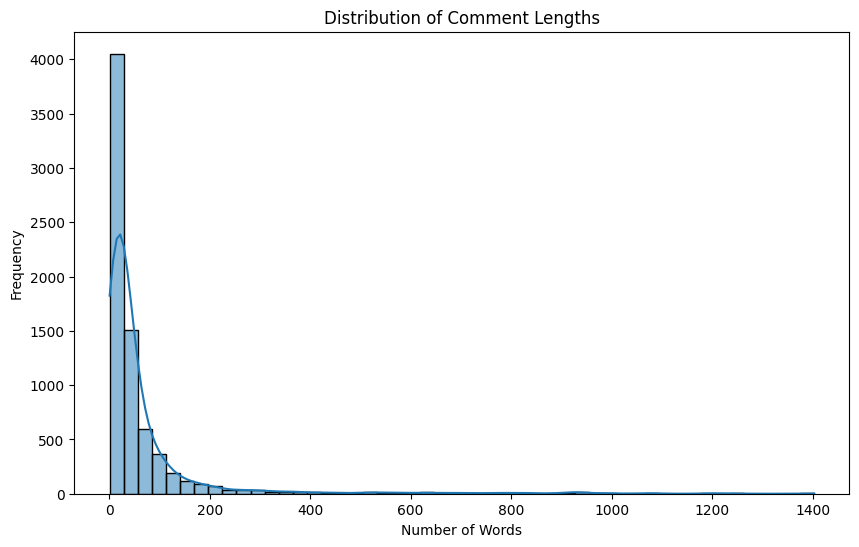

In [39]:
plot_words_frequencies(df)

Plotting the length frequencies of words, it is possible to notice that the majority of comments have the **amount of words between 1 and 200**, and the rest of comments with words > 200 are infrequent.

Probably the comments with words > 200 are not useful for model training.

**This number helps to define the pad length to apply to sentences**.

### 5.5.2 Words Amount Analysis

Lets study and understand the amount of words that could be useful to use fro tokenizer and cover the majority number of words.

In [40]:
# Initialize the Tokenizer without number of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_comment'])

In [41]:
# Take the words count of entire corpus (related to all comments)
word_counts = tokenizer.word_counts

# Sort the words and related frequency in order to have a list of words ordered by frequency
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [42]:
# Take the counts of each word
cumulative_counts = [count for word, count in sorted_word_counts]

# Calculate the cumulative words count
cumulative_counts = pd.Series(cumulative_counts).cumsum()

# Take from Series the cumulative sum
total_counts = cumulative_counts.iloc[-1]

# Trasform the sum into percentage
cumulative_percentage = cumulative_counts / total_counts * 100

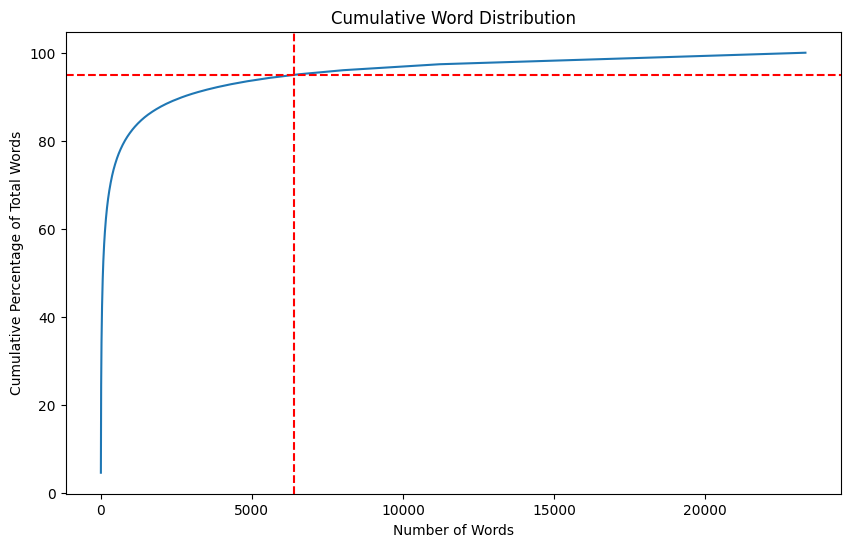

In [43]:
# Plot the cumulative distribution
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(cumulative_percentage) + 1), y=cumulative_percentage)
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Percentage of Total Words')
plt.title('Cumulative Word Distribution')
plt.axhline(y=95, color='r', linestyle='--')
plt.axvline(x=len(cumulative_percentage[cumulative_percentage <= 95]), color='r', linestyle='--')
plt.show()

Plotting the cumulative counts of word frequencies, it can possible to notice that 95% of words coverage is about 2700 words in total.

**This number helps to define the num_words into tokenizer.**

In [44]:
# Show the number of words that cover the 95% of all corpus text
num_words_95_percentage = len(cumulative_percentage[cumulative_percentage <= 95])
print(f'Number of words covering 95% of the corpus: {num_words_95_percentage}')

Number of words covering 95% of the corpus: 6405


# 6 Data Pre-Processing

## 6.1 Features and Labels Definition

Define the features and labels from dataframe.

In [45]:
# Select Features and Labels from dataframe
X = df['cleaned_comment'].values
y = df[LABELS].values

In [46]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=RANDOM_SEED)

In [47]:
# Check the train and test data shape
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (5874,)
X_test shape: (1469,)
y_train shape: (5874, 6)
y_test shape: (1469, 6)


## 6.2 Text Pre-Processing: Tokenizer, Sentences and Padding

Create the tokenizer with the number of words coverage analyzed.

In [48]:
# Define the number of max words
num_words = num_words_95_percentage

# Define a Tokenizer used to create the vocabulary and remove all semantic contribution
tokenizer = Tokenizer(num_words=num_words)

In [49]:
# Fit on text the tokenizer created
tokenizer.fit_on_texts(X_train)

Compute the vocabulary size useful  for Neural Network definition.

In [50]:
# Calculate the vocabulary size
vocabulary_size = len(tokenizer.word_index)+1
print(f'Vocabulary Size: {vocabulary_size}')

Vocabulary Size: 20547


Create the sentences from text

In [51]:
# Transform the text into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

As studied and noticed before into plot of length words frequency, the most length appeared is about 200 and then the padding to be added to sequences could be 200.

In [52]:
# Define the max length for padding
max_length = 200

# Apply the padding to sequences
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

The data are ready to be used from AI model.

# 7 Model Exploration

## 7.1 Callbacks definition

Solving a classification problem the most metrics used for its are f1-score, Precision, Recall then a specific callback has been defined.

In particular, the callback, calculate at the end of each epoch the f1-score and checks if the currently value is the best comparing the previous score.

In [53]:
# Define Callback: F1ScoreCallback
f1_callback = F1ScoreCallback(validation_data=(padded_test_sequences, y_test), patience=2, verbose=1)
f1_callback_2 = F1ScoreCallback(validation_data=(padded_test_sequences, y_test), patience=2, verbose=1)
f1_callback_3 = F1ScoreCallback(validation_data=(padded_test_sequences, y_test), patience=2, verbose=1)
f1_callback_4 = F1ScoreCallback(validation_data=(padded_test_sequences, y_test), patience=2, verbose=1)
f1_callback_5 = F1ScoreCallback(validation_data=(padded_test_sequences, y_test), patience=2, verbose=1)

## 7.2 Build Models: RNN

Try to fit different type of models such as: BiLSTM, LSTM with Normalization, GRU and RNN with class weights.

In [54]:
baseline_model = create_baseline_model(vocabulary_size, max_length, LABELS_COUNT)
history_baseline = baseline_model.fit(padded_train_sequences, y_train, epochs=10, batch_size=32, validation_split=0.2, validation_data=(padded_test_sequences, y_test), callbacks=[f1_callback])
baseline_loss, baseline_accuracy = baseline_model.evaluate(padded_test_sequences, y_test)
print(f'Baseline Test Loss: {baseline_loss}')
print(f'Baseline Test Accuracy: {baseline_accuracy}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Epoch 1: F1-Score: 0.7830
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6848 - loss: 0.5625 - val_accuracy: 0.6637 - val_loss: 0.3128
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Epoch 2: F1-Score: 0.8524
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6177 - loss: 0.2821 - val_accuracy: 0.5745 - val_loss: 0.2310
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score: 0.8860
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5279 - loss: 0.2133 - val_accuracy: 0.5255 - val_loss: 0.2196
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Epoch 4: F1-Score: 0.9137
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5324 - loss: 0.1767 - val_accuracy: 0.4949 - val_loss: 0.1770
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 5: F1-Score: 0.9143
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4529 - loss: 0.1502 - val_accuracy: 0.4336 - val_loss: 0.1711
Epoch 6/10
46/46 ━━━━━━━━

In [55]:
bilstm_model = create_bilstm_model(vocabulary_size, max_length, LABELS_COUNT)
history_bilstm = bilstm_model.fit(padded_train_sequences, y_train, epochs=10, batch_size=32, validation_split=0.2, validation_data=(padded_test_sequences, y_test), callbacks=[f1_callback_2])
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(padded_test_sequences, y_test)
print(f'BiLSTM Test Loss: {bilstm_loss}')
print(f'BiLSTM Test Accuracy: {bilstm_accuracy}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Epoch 1: F1-Score: 0.7627
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8303 - loss: 0.5687 - val_accuracy: 0.7250 - val_loss: 0.3218
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Epoch 2: F1-Score: 0.8598
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7178 - loss: 0.2920 - val_accuracy: 0.5378 - val_loss: 0.2387
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Epoch 3: F1-Score: 0.8723
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5603 - loss: 0.2209 - val_accuracy: 0.6133 - val_loss: 0.2198
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Epoch 4: F1-Score: 0.8943
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5505 - loss: 0.1979 - val_accuracy: 0.5099 - val_loss: 0.2001
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Epoch 5: F1-Score: 0.8951
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5184 - loss: 0.1654 - val_accuracy: 0.4820 - val_loss: 0.1876
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━

In [56]:
gru_model = create_gru_model(vocabulary_size, max_length, LABELS_COUNT)
history_gru = gru_model.fit(padded_train_sequences, y_train, epochs=10, batch_size=32, validation_split=0.2, validation_data=(padded_test_sequences, y_test), callbacks=[f1_callback_3])
gru_loss, gru_accuracy = gru_model.evaluate(padded_test_sequences, y_test)
print(f'GRU Test Loss: {gru_loss}')
print(f'GRU Test Accuracy: {gru_accuracy}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Epoch 1: F1-Score: 0.8200
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5781 - loss: 0.5798 - val_accuracy: 0.7740 - val_loss: 0.2850
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Epoch 2: F1-Score: 0.8794
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6246 - loss: 0.2685 - val_accuracy: 0.5446 - val_loss: 0.2201
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score: 0.8977
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5373 - loss: 0.1974 - val_accuracy: 0.5112 - val_loss: 0.1939
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score: 0.9117
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5244 - loss: 0.1673 - val_accuracy: 0.4820 - val_loss: 0.1809
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Epoch 5: F1-Score: 0.9129
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4933 - loss: 0.1315 - val_accuracy: 0.4187 - val_loss: 0.1747
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━

In [57]:
ltsm_norm_model = create_biltsm_normalization_model(vocabulary_size, max_length, LABELS_COUNT)
history_ltsm_norm = ltsm_norm_model.fit(padded_train_sequences, y_train, epochs=10, batch_size=32, validation_split=0.2, validation_data=(padded_test_sequences, y_test), callbacks=[f1_callback_4])
ltsm_norm_loss, ltsm_norm_accuracy = ltsm_norm_model.evaluate(padded_test_sequences, y_test)
print(f'LTSM Norm Test Loss: {ltsm_norm_loss}')
print(f'LTSM Norm Test Accuracy: {ltsm_norm_accuracy}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Epoch 1: F1-Score: 0.2376
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.2133 - loss: 5.5018 - val_accuracy: 0.0027 - val_loss: 4.1310
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Epoch 2: F1-Score: 0.5297
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2373 - loss: 3.8912 - val_accuracy: 0.0048 - val_loss: 3.0153
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Epoch 3: F1-Score: 0.7283
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2750 - loss: 2.8080 - val_accuracy: 0.1253 - val_loss: 2.2522
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Epoch 4: F1-Score: 0.8144
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.3117 - loss: 2.1344 - val_accuracy: 0.2396 - val_loss: 1.7417
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Epoch 5: F1-Score: 0.8535
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3258 - loss: 1.6796 - val_accuracy: 0.4016 - val_loss: 1.3913
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━

In [58]:
model_with_weights = create_model_with_class_weights(vocabulary_size, max_length, LABELS_COUNT, padded_train_sequences, y_train)
history_with_weights = model_with_weights.fit(padded_train_sequences, y_train, epochs=10, batch_size=32, validation_split=0.2, validation_data=(padded_test_sequences, y_test), callbacks=[f1_callback_5])
with_weights_loss, with_weights_accuracy = model_with_weights.evaluate(padded_test_sequences, y_test)
print(f'Model with Weights Test Loss: {ltsm_norm_loss}')
print(f'Model with Weights Test Accuracy: {ltsm_norm_accuracy}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6371 - loss: 0.5457 - val_accuracy: 0.6698 - val_loss: 0.3987
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5085 - loss: 0.2812 - val_accuracy: 0.5149 - val_loss: 0.2568
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4450 - loss: 0.2037 - val_accuracy: 0.4562 - val_loss: 0.2307
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4497 - loss: 0.1722 - val_accuracy: 0.4315 - val_loss: 0.2137
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4041 - loss: 0.1400 - val_accuracy: 0.4060 - val_loss: 0.2074
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3760 - loss: 0.1253 - val_accuracy: 0.4170 - val_loss: 0.2011
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3501 - loss: 0.1054 - val_accuracy: 0.3915 - val_loss: 0.1962
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3593 - loss: 0.0903 - val_accuracy: 0.437

## 7.3 Model Performance Comparison

### 7.3.1 Accuracy and Loss Comparison

In [59]:
performance = {
    'Model': ['Baseline LSTM', 'BiLSTM', 'GRU', 'LSTM Norm', 'Model with Weights'],
    'Test Accuracy': [baseline_accuracy, bilstm_accuracy, gru_accuracy, ltsm_norm_accuracy, with_weights_accuracy],
    'Test Loss': [baseline_loss, bilstm_loss, gru_loss, ltsm_norm_loss, with_weights_loss]
}

performance_df = pd.DataFrame(performance)

<ipython-input-17-1b2893783e16>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=data, palette='viridis')


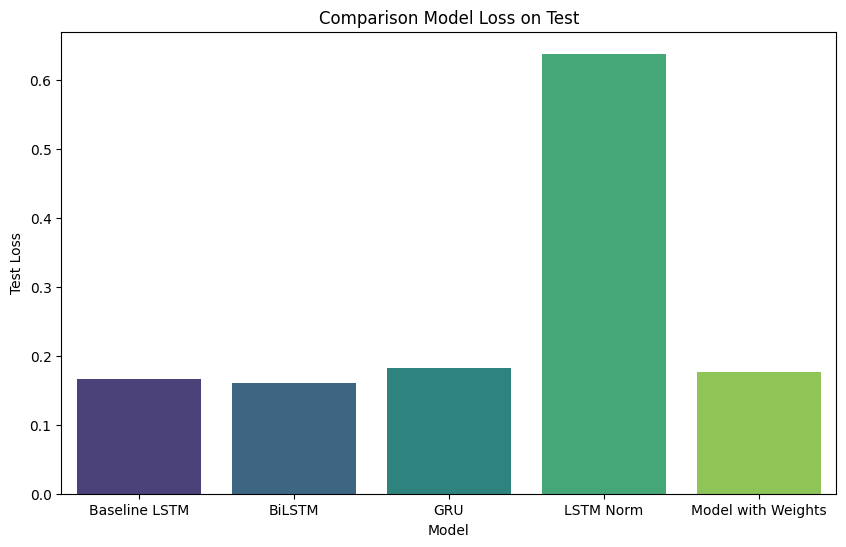

<ipython-input-17-1b2893783e16>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=data, palette='viridis')


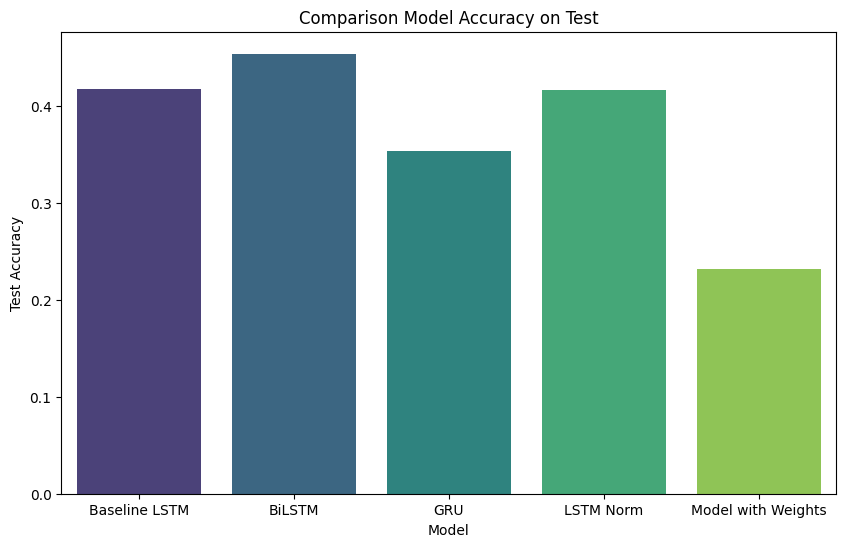

In [60]:
plot_model_performance('Comparison Model Loss on Test', 'Model', 'Test Loss', 'Model', 'Test Loss', performance_df)
plot_model_performance('Comparison Model Accuracy on Test', 'Model', 'Test Accuracy', 'Model', 'Test Accuracy', performance_df)

Looking the Accuracy and Loss Function of models, it is possible to notice that the **worst** model is **Model with Weights** and the **best** are the **Baseline LSTM** and **BiLSTM**.

### 7.3.2 Identify Best Thresholds

Compute the best thresholds for each label in order to convert the binary predicitons with more accuracy.

In [61]:
best_thresholds_baseline_model = find_best_thresholds(y_test, baseline_model.predict(y_test))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold for label 0 is 0.30 with F1 score 0.9840
Best threshold for label 1 is 0.28 with F1 score 0.8523
Best threshold for label 2 is 0.22 with F1 score 0.9633
Best threshold for label 3 is 0.11 with F1 score 0.6941
Best threshold for label 4 is 0.21 with F1 score 0.9823
Best threshold for label 5 is 0.27 with F1 score 0.6354


In [62]:
best_thresholds_bilstm_model = find_best_thresholds(y_test, bilstm_model.predict(y_test))

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Best threshold for label 0 is 0.61 with F1 score 0.9899
Best threshold for label 1 is 0.34 with F1 score 0.7585
Best threshold for label 2 is 0.24 with F1 score 0.9664
Best threshold for label 3 is 0.07 with F1 score 0.7092
Best threshold for label 4 is 0.24 with F1 score 0.9593
Best threshold for label 5 is 0.00 with F1 score 0.4238


In [63]:
best_thresholds_gru_model = find_best_thresholds(y_test, gru_model.predict(y_test))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold for label 0 is 0.01 with F1 score 0.9840
Best threshold for label 1 is 0.47 with F1 score 0.7412
Best threshold for label 2 is 0.04 with F1 score 0.9374
Best threshold for label 3 is 0.02 with F1 score 0.6857
Best threshold for label 4 is 0.01 with F1 score 0.9529
Best threshold for label 5 is 0.00 with F1 score 0.4238


In [64]:
best_thresholds_ltsm_norm_model = find_best_thresholds(y_test, ltsm_norm_model.predict(y_test))

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Best threshold for label 0 is 0.77 with F1 score 0.9899
Best threshold for label 1 is 0.51 with F1 score 0.6791
Best threshold for label 2 is 0.78 with F1 score 0.9608
Best threshold for label 3 is 0.15 with F1 score 0.6857
Best threshold for label 4 is 0.67 with F1 score 0.9694
Best threshold for label 5 is 0.00 with F1 score 0.4238


In [65]:
best_thresholds_model_with_weights = find_best_thresholds(y_test, model_with_weights.predict(y_test))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold for label 0 is 0.17 with F1 score 0.9876
Best threshold for label 1 is 0.30 with F1 score 0.6784
Best threshold for label 2 is 0.33 with F1 score 0.9633
Best threshold for label 3 is 0.05 with F1 score 0.7092
Best threshold for label 4 is 0.18 with F1 score 0.9716
Best threshold for label 5 is 0.00 with F1 score 0.4238


### 7.3.3 Classification Report Comparison

Generate the classification reports for each model and compare the metrics in order to understand which is the best.

In [66]:
generate_classification_report(baseline_model, padded_test_sequences, y_test, best_thresholds_baseline_model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
               precision    recall  f1-score   support

        toxic       0.95      0.97      0.96       835
 severe_toxic       0.80      0.88      0.84       363
      obscene       0.90      0.97      0.94       624
       threat       0.84      1.00      0.91       456
       insult       0.85      0.97      0.91       640
identity_hate       0.73      0.91      0.81       395

    micro avg       0.86      0.96      0.91      3313
    macro avg       0.85      0.95      0.89      3313
 weighted avg       0.86      0.96      0.91      3313
  samples avg       0.51      0.57      0.53      3313



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
generate_classification_report(bilstm_model, padded_test_sequences, y_test, best_thresholds_bilstm_model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
               precision    recall  f1-score   support

        toxic       0.97      0.95      0.96       835
 severe_toxic       0.80      0.90      0.85       363
      obscene       0.91      0.97      0.94       624
       threat       0.89      1.00      0.94       456
       insult       0.89      0.96      0.92       640
identity_hate       0.27      1.00      0.42       395

    micro avg       0.70      0.96      0.81      3313
    macro avg       0.79      0.96      0.84      3313
 weighted avg       0.83      0.96      0.87      3313
  samples avg       0.48      0.57      0.51      3313



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
generate_classification_report(gru_model, padded_test_sequences, y_test, best_thresholds_gru_model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
               precision    recall  f1-score   support

        toxic       0.87      0.99      0.92       835
 severe_toxic       0.82      0.86      0.84       363
      obscene       0.82      0.98      0.89       624
       threat       0.74      1.00      0.85       456
       insult       0.73      0.98      0.84       640
identity_hate       0.27      1.00      0.42       395

    micro avg       0.64      0.97      0.77      3313
    macro avg       0.71      0.97      0.79      3313
 weighted avg       0.74      0.97      0.82      3313
  samples avg       0.45      0.58      0.50      3313



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
generate_classification_report(ltsm_norm_model, padded_test_sequences, y_test, best_thresholds_ltsm_norm_model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
               precision    recall  f1-score   support

        toxic       0.97      0.84      0.90       835
 severe_toxic       0.78      0.74      0.76       363
      obscene       0.96      0.79      0.87       624
       threat       0.64      1.00      0.78       456
       insult       0.93      0.81      0.86       640
identity_hate       0.27      1.00      0.42       395

    micro avg       0.65      0.85      0.74      3313
    macro avg       0.76      0.86      0.76      3313
 weighted avg       0.81      0.85      0.80      3313
  samples avg       0.46      0.50      0.46      3313



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
generate_classification_report(model_with_weights, padded_test_sequences, y_test, best_thresholds_model_with_weights)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
               precision    recall  f1-score   support

        toxic       0.95      0.96      0.96       835
 severe_toxic       0.82      0.86      0.84       363
      obscene       0.94      0.95      0.95       624
       threat       0.87      1.00      0.93       456
       insult       0.87      0.97      0.92       640
identity_hate       0.27      1.00      0.42       395

    micro avg       0.70      0.96      0.81      3313
    macro avg       0.79      0.96      0.84      3313
 weighted avg       0.83      0.96      0.87      3313
  samples avg       0.48      0.57      0.51      3313



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Looking the classification reports, as expected also from previous comparison, the best model is the Baseline model.

# 8 Model Tests

Create the new comments and test the model after the training.

In [71]:
toxic_comments = [
    "You are such an idiot. No one cares about your stupid opinions!",
    "You're the most worthless piece of garbage I've ever encountered. Just go away.",
    "I hope you rot in hell for the rest of eternity, you despicable person.",
    "Shut up, you pathetic loser. No one wants to hear your whining.",
    "You're nothing but a lying, cheating scumbag. Get lost!"
]


severe_toxic_comments = [
    "ARE YOU FUCKING KIDDING ME? WHAT THE HELL ARE YOU EVEN TALKING ABOUT? THIS IS NONE OF YOUR DAMN BUSINESS. WHY DO YOU FEEL THE NEED TO STICK YOUR NOSE WHERE IT DOESN'T BELONG? I'VE CONTRIBUTED PLENTY TO THIS PAGE. IF SOMEONE HAS A PROBLEM, THEY CAN CONTACT ME DIRECTLY WITHOUT YOU BUTTING IN. SO BACK OFF.",
    "screw off. screw off. screw off. screw off. screw off. screw off. screw off. screw off. screw off. screw off. screw off. screw off. screw off. screw off.",
    "YOU ARE SO FUCKING STUPID. DO YOU EVEN KNOW HOW TO READ? YOUR COMMENTS ARE JUST A BUNCH OF GARBAGE. NO ONE CARES ABOUT YOUR OPINION.",
    "Just shut the hell up. shut the hell up. shut the hell up.",
    "GO DIE IN A FIRE. LOL. JUST JOKING. HAHAHAHAHA. BUT SERIOUSLY, NO ONE WANTS YOU HERE. YOU'RE A WASTE OF SPACE AND TIME. NO MATTER WHAT YOU DO, YOU CAN'T STOP ME. DEAL WITH IT."
]

obscene_comments = [
    "You're a bitch with no life!",
    "Fuck that shit, suck my dick",
    "Asshole, go to take dick in ass, stupid bastard",
    "SUCK MY DICK! SUCK MY DICK!",
    "mOTHER FUCKer! FAK!"
]

threat_comments = [
    "Keep talking and you'll regret it when someone shows up at your door.",
    "You better watch out, because I'll find you and make you pay.",
    "Shut up, or I'll come over and deal with you myself.",
    "You're such a pathetic loser. I hope you get what's coming to you.",
    "Keep running your mouth and see what happens when I catch up with you."
]

insult_comments = [
    "FUCK YOU",
    "MOTHERFUCKER LOSER",
    "Fat retarded!",
    "youre a rat!",
    "fat bitch nigga"
]

identity_hate_comments = [
    "Go back to where you came from, you don't belong here.",
    "What is wrong with you, you filthy Muslim? Stay away from our discussions.",
    "You dirty pig, why do you always meddle in things that don't concern you?",
    "You're nothing but a low-life, uneducated person from a backward country.",
    "Get lost, we don't need your kind messing up this space."
]

positive_comments = [
    "YOU ARE MY HERO!",
    "Ty for supporting and let me know how to do this stuff!",
    "THANKS MAN FOR THIS, U R SPECIAL",
    "Where can i find it? I NEED THIS PLEASE!",
    "dO U understand the question? I think that you didn't get th point. I'm saying that you could tkae this stuff from another place and probably they are better than yours."
]

In [72]:
dict_comments = {
    'toxic': toxic_comments,
    'severe_toxic': severe_toxic_comments,
    'obscene': obscene_comments,
    'threat': threat_comments,
    'insult': insult_comments,
    'identity_hate': identity_hate_comments,
    'positive': positive_comments
}

In [74]:
process_and_predict_comments(dict_comments, tokenizer, baseline_model, max_length, best_thresholds_baseline_model)


Label: toxic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Comment: You are such an idiot. No one cares about your stupid opinions!
Binary Prediction: [1 1 1 0 1 1]

Comment: You're the most worthless piece of garbage I've ever encountered. Just go away.
Binary Prediction: [1 1 1 0 1 1]

Comment: I hope you rot in hell for the rest of eternity, you despicable person.
Binary Prediction: [1 0 0 1 1 0]

Comment: Shut up, you pathetic loser. No one wants to hear your whining.
Binary Prediction: [1 1 1 0 1 1]

Comment: You're nothing but a lying, cheating scumbag. Get lost!
Binary Prediction: [1 0 0 0 0 1]


Label: severe_toxic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Comment: ARE YOU FUCKING KIDDING ME? WHAT THE HELL ARE YOU EVEN TALKING ABOUT? THIS IS NONE OF YOUR DAMN BUSINESS. WHY DO YOU FEEL THE NEED TO STICK YOUR NOSE WHERE IT DOESN'T BELONG? I'VE CONTRIBUTED PLENTY TO THIS PAGE. IF SOMEONE HAS A PROBLEM, THEY CAN CONTACT ME DIRECTLY WITHOUT YOU BUTTING IN. SO BACK OFF.
Binary Prediction: [1 1 

Chosing the best model comparing the classification report, the baseline model (LSTM), the tests are wuite good for each label.

Furthermore, it can identify also the positive comments.

# 9 Conclusion



In this project, we tackled a multilabel classification problem and implemented various techniques to optimize the model performance. By employing conditional probability-based sampling, we successfully balanced the dataset and improved the representativeness of the samples. The process of determining optimal thresholds for each label, with a focus on maximizing the F1-score, significantly enhanced the precision and recall of our predictions.

The model evaluations revealed that while some labels had exceptional performance, others faced challenges due to inherent data imbalances or insufficient feature representation. Our approach to sampling and threshold optimization played a crucial role in addressing these issues and refining the model's accuracy.

Despite the successes, several challenges were encountered, including managing data imbalance . Future work could benefit from incorporating advanced sampling techniques and optimizing hyperparameters further to achieve even better results.

Overall, the project has demonstrated the effectiveness of combining probabilistic sampling with threshold tuning in multilabel classification tasks. The insights gained provide a solid foundation for applying similar methodologies to related problems and underscore the importance of careful data preparation and model evaluation.